In [6]:
import mne
from mne.preprocessing import ICA


import mtrf
from mtrf.model import TRF
from mtrf.stats import crossval, nested_crossval
#import eelbrain as eel

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np
import scipy
from scipy.io import wavfile, loadmat, savemat
from scipy.signal import hilbert


import librosa
import librosa.display
import mido

import sys
sys.path.append('../utils')
from pp_utils import *
from plot_utils import *
from mTRF_utils import *
from midi_utils import *
from update_sub_lists import*

import pickle


In [7]:

good_listen_subjects, good_motor_subjects, musicians, nonmusicians = load_subject_lists()

### Group statistics 
Reload the .mat data with all the mTRF kernels 

In [8]:
mTRF_path = '/Users/cindyzhang/Documents/M2/Audiomotor_Piano/AM-EEG/analysis_listen/listen_mTRF_data/listen_mTRF_data_normalized_onsets'
load_stimuli = False

In [9]:
#loading data and concatenating mTRF and r values to master lists with all participants

subjects_to_process = [
                       '01', '02', '04', '05', '06', '07', '08', '09', 
                       '10', '11', '12', '13', '14', '15', '16', '17', '18',
                       '19', 
    '20', '21'
                       ]


musicians = ['02', '06', '07', '12', '13', '14', '15', '17', '18', '21']

periods = ['pre', 'post']

In [10]:
#import r values in dataframe form

# Initialize the DataFrame
mtrf_df = pd.DataFrame(columns=['subject', 'group', 'period', 'mean_r'])

# Iterate over subjects and periods to populate the DataFrame
for subject in subjects_to_process:
    for period in periods:
        # Load the data from the .mat file
        mTRF_data = loadmat(f'{mTRF_path}/mTRF_normalized_listen_{period}_{subject}.mat')
        
        # Determine the group based on the subject
        if subject in musicians:
            group = 'musicians'
        else:
            group = 'nonmusicians'
        
        # Calculate the mean of 'r' values
        mean_r = mTRF_data['r'][0].mean()
        mTRF_weights = mTRF_data['weights']

        if load_stimuli:
            stimuli_segments = mTRF_data['stimuli']
        
        # Append a new row to the DataFrame
        mtrf_df = mtrf_df.append({
            'subject': subject,
            'group': group,
            'period': period,
            'mean_r': mean_r,
            'mTRF_weights': mTRF_weights,
           # 'stimuli_segments': stimuli_segments
        }, ignore_index=True)


/var/folders/18/hp_602x50x34x_4p_qjc80g40000gn/T/ipykernel_7535/862685102.py:26: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mtrf_df = mtrf_df.append({
/var/folders/18/hp_602x50x34x_4p_qjc80g40000gn/T/ipykernel_7535/862685102.py:26: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mtrf_df = mtrf_df.append({
/var/folders/18/hp_602x50x34x_4p_qjc80g40000gn/T/ipykernel_7535/862685102.py:26: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mtrf_df = mtrf_df.append({
/var/folders/18/hp_602x50x34x_4p_qjc80g40000gn/T/ipykernel_7535/862685102.py:26: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mtrf_df = mtrf_df.append({
/var/folders/18/hp_602x50x34

In [11]:
#plotting stimuli support vectors
"""fig, axes = plt.subplots(2, 1, figsize = (8,6))

for i in [0,1]:

    axes[i].plot(mtrf_df['stimuli_segments']
            [0]#subject
            [3] #segment number
            [:,i]
            ,
            color = 'grey'
            )

axes[0].set_title('Onsets', fontsize = 10)
axes[1].set_title('Surprisal', fontsize = 10)

plt.tight_layout()"""

"fig, axes = plt.subplots(2, 1, figsize = (8,6))\n\nfor i in [0,1]:\n\n    axes[i].plot(mtrf_df['stimuli_segments']\n            [0]#subject\n            [3] #segment number\n            [:,i]\n            ,\n            color = 'grey'\n            )\n\naxes[0].set_title('Onsets', fontsize = 10)\naxes[1].set_title('Surprisal', fontsize = 10)\n\nplt.tight_layout()"

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

pre vs. post: Wilcoxon test (paired samples), P_val:1.367e-02 Stat=4.000e+00
p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

pre vs. post: Wilcoxon test (paired samples), P_val:3.750e-01 Stat=1.800e+01


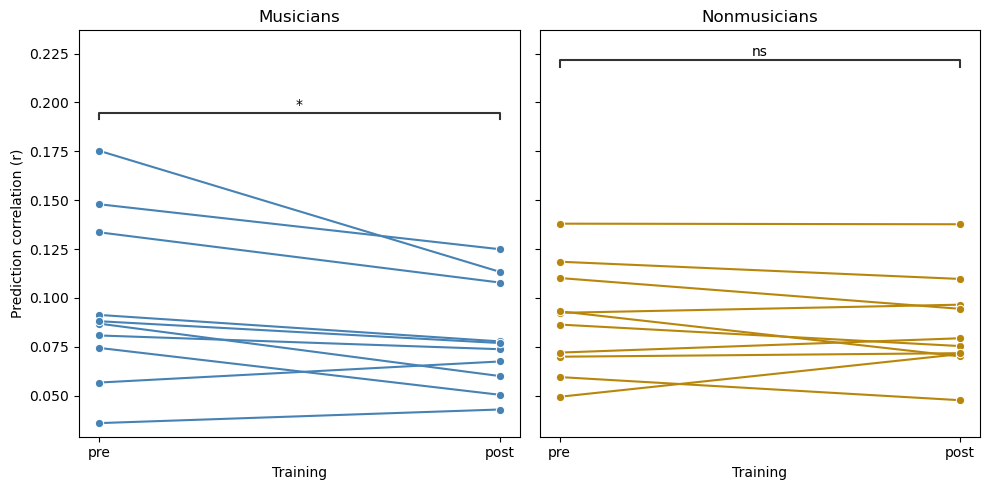

In [12]:
from statannotations.Annotator import Annotator

# Create the plot
fig, axs = plt.subplots(1, 2, figsize=(10, 5), sharey=True)

# Define the groups and corresponding colors
groups = ['musicians', 'nonmusicians']
colors = ['steelblue', 'darkgoldenrod']  # Define specific colors for musicians and nonmusicians

# Loop through each group to create subplots
for j, group in enumerate(groups):
    # Subset the DataFrame for the current group
    df_group = mtrf_df[mtrf_df['group'] == group]
    
    # Create the plot using Seaborn with a specific color for each group
    sns.lineplot(
        data=df_group,
        x='period',
        y='mean_r',
        hue='subject',
        marker='o',
        ax=axs[j],
        legend=None,
        palette=[colors[j]] * df_group['subject'].nunique()  # Use the same color for all subjects in the group
    )

    # Statistical annotation
    pairs = [('pre', 'post')]
    annotator = Annotator(axs[j], pairs, data=df_group, x='period', y='mean_r')
    annotator.configure(test='Wilcoxon', text_format='star', loc='inside')
    annotator.apply_and_annotate()
    
    axs[j].set_title(group.capitalize())
    axs[j].set_ylabel('Prediction correlation (r)')
    axs[j].set_xlabel('Training')

# Adjust layout and display the plot
plt.tight_layout()
plt.show()


p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

pre vs. post: Wilcoxon test (paired samples), P_val:1.367e-02 Stat=4.000e+00
p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

pre vs. post: Wilcoxon test (paired samples), P_val:3.750e-01 Stat=1.800e+01


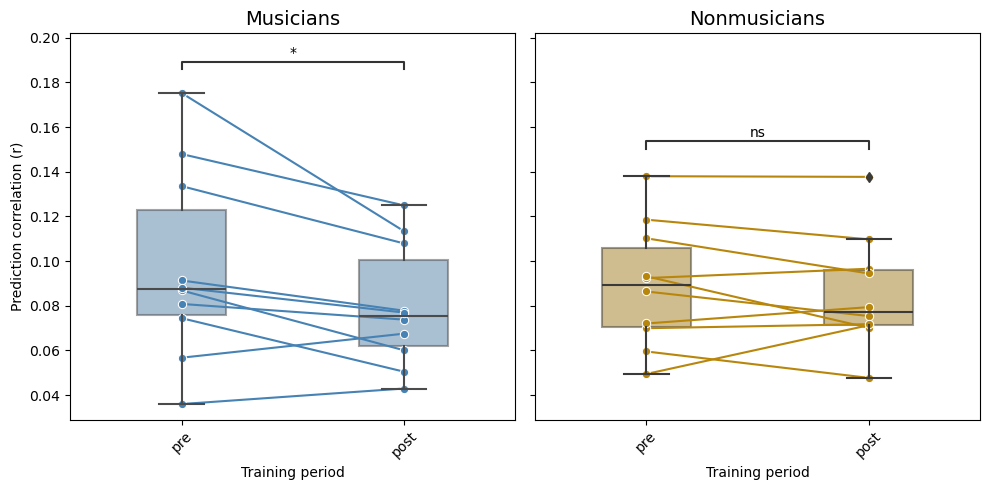

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt
from statannotations.Annotator import Annotator

# Create the plot with shared y-axis
fig, axs = plt.subplots(1, 2, figsize=(10, 5), sharey=True)

# Define the groups and corresponding colors
groups = ['musicians', 'nonmusicians']
colors = ['steelblue', 'darkgoldenrod']  # Colors for musicians and nonmusicians

# Loop through each group to create subplots
for j, group in enumerate(groups):
    # Subset the DataFrame for the current group
    df_group = mtrf_df[mtrf_df['group'] == group]

    # Plot individual subject lines
    sns.lineplot(
        data=df_group,
        x='period',
        y='mean_r',
        hue='subject',
        marker='o',
        ax=axs[j],
        legend=None,
        palette=[colors[j]] * df_group['subject'].nunique()  # Uniform color for subjects
    )

    # Add a box plot to show the summary statistics
    sns.boxplot(
        data=df_group,
        x='period',
        y='mean_r',
        ax=axs[j],
        color=colors[j],
        width=0.4,  # Adjust width to avoid overlap
        boxprops=dict(alpha=0.5)  # Semi-transparent to show both box and line
    )

    # Statistical annotation
    pairs = [('pre', 'post')]
    annotator = Annotator(axs[j], pairs, data=df_group, x='period', y='mean_r')
    annotator.configure(test='Wilcoxon', text_format='star', loc='inside')
    annotator.apply_and_annotate()
    
    # Set title and labels
    axs[j].set_title(group.capitalize(), fontsize=14)
    axs[j].set_ylabel('Prediction correlation (r)')
    axs[j].set_xlabel('Training period')
    axs[j].tick_params(axis='x', rotation=45)

# Adjust layout and display the plot
plt.tight_layout()
plt.show()


In [14]:
"""
wilcoxon(df[(df['period']=='pre') & (df['group']== 'musicians')]['mean_r'], 
                df[(df['period']=='post') & (df['group']=='musicians')]['mean_r'])
"""

"\nwilcoxon(df[(df['period']=='pre') & (df['group']== 'musicians')]['mean_r'], \n                df[(df['period']=='post') & (df['group']=='musicians')]['mean_r'])\n"

### mTRF visualization

In [15]:
mean_weights = mtrf_df['mTRF_weights'].mean() #averaging mTRF weights across all subjects

#load time vector
with open('/Users/cindyzhang/Documents/M2/Audiomotor_Piano/AM-EEG/utils/mTRF_times-0_1to0_3.pkl', 'rb') as file:
    mtrf_times = pickle.load(file)

In [16]:
#plot AM mTRF
"""fig, axes = plt.subplots(2,1)

for i in range(mean_weights.shape[0]):
    axes[i].plot(mtrf_times, mean_weights[i,:])

axes[0].set_title('Onsets')
axes[1].set_title('Surprisal')

plt.tight_layout()"""

"fig, axes = plt.subplots(2,1)\n\nfor i in range(mean_weights.shape[0]):\n    axes[i].plot(mtrf_times, mean_weights[i,:])\n\naxes[0].set_title('Onsets')\naxes[1].set_title('Surprisal')\n\nplt.tight_layout()"

In [17]:
mean_weights.shape

(1, 53, 64)

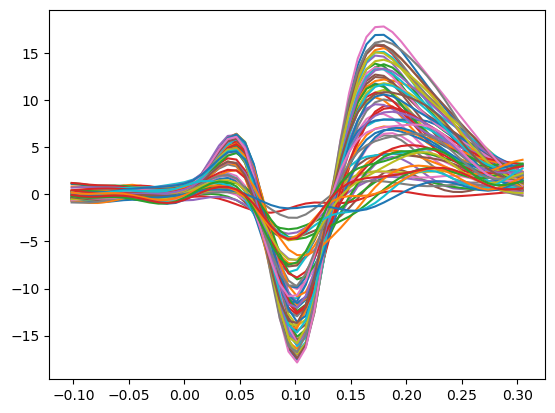

In [18]:
#plot onset only mTRF
plt.figure()
plt.plot(mtrf_times, mean_weights[0])

In [19]:
good_listen_subjects.remove('03')

### Comparing onset-only and AM mTRFs

In [32]:
#loading all mTRF data (r values only)

periods = ['pre', 'post']
features_tocompare = ['onsets', 'surprisal']

subjects_to_process = good_listen_subjects

mtrf_df_tocompare = pd.DataFrame(columns=['subject', 'group', 'period', 'mean_r', 'features'])

for feature in features_tocompare:
    mtrf_dir_tocompare = f'/Users/cindyzhang/Documents/M2/Audiomotor_Piano/AM-EEG/analysis_listen/listen_mTRF_data/listen_mTRF_data_normalized_{feature}'
    for subject in subjects_to_process:
        for period in periods:
            # Load the data from the .mat file
            mTRF_data = loadmat(f'{mtrf_dir_tocompare}/mTRF_normalized_listen_{period}_{subject}.mat')
            
            # Determine the group based on the subject
            if subject in musicians:
                group = 'musicians'
            else:
                group = 'nonmusicians'
            
            # Calculate the mean of 'r' values
            mean_r = mTRF_data['r'][0].mean()
            mTRF_weights = mTRF_data['weights']

            if load_stimuli:
                stimuli_segments = mTRF_data['stimuli']
            
            # Append a new row to the DataFrame
            mtrf_df_tocompare = mtrf_df_tocompare.append({
                'subject': subject,
                'group': group,
                'period': period,
                'mean_r': mean_r,
                'features': feature
               
            }, ignore_index=True)


/var/folders/18/hp_602x50x34x_4p_qjc80g40000gn/T/ipykernel_7535/1291429277.py:31: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mtrf_df_tocompare = mtrf_df_tocompare.append({
/var/folders/18/hp_602x50x34x_4p_qjc80g40000gn/T/ipykernel_7535/1291429277.py:31: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mtrf_df_tocompare = mtrf_df_tocompare.append({
/var/folders/18/hp_602x50x34x_4p_qjc80g40000gn/T/ipykernel_7535/1291429277.py:31: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mtrf_df_tocompare = mtrf_df_tocompare.append({
/var/folders/18/hp_602x50x34x_4p_qjc80g40000gn/T/ipykernel_7535/1291429277.py:31: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat in

In [33]:
mtrf_df_tocompare

,subject,group,period,mean_r,features
0,01,nonmusicians,pre,0.086382,onsets
1,01,nonmusicians,post,0.075381,onsets
2,02,musicians,pre,0.133554,onsets
3,02,musicians,post,0.107882,onsets
4,04,nonmusicians,pre,0.059532,onsets
...,...,...,...,...,...
75,19,nonmusicians,post,0.138093,surprisal
76,20,nonmusicians,pre,0.071967,surprisal
77,20,nonmusicians,post,0.079049,surprisal
78,21,musicians,pre,0.057049,surprisal


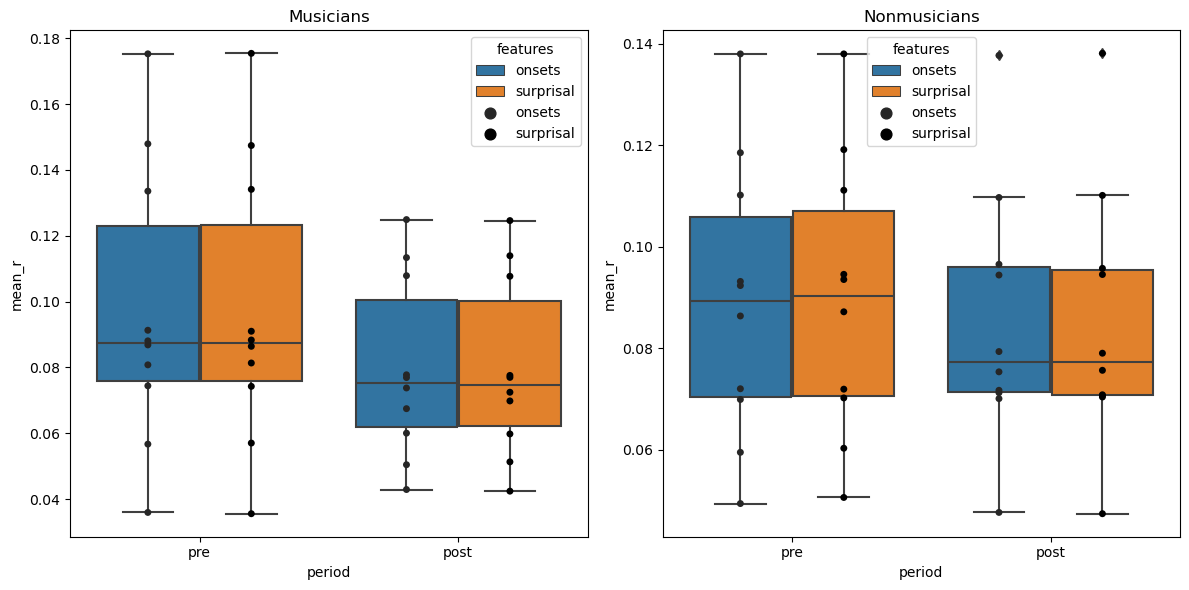

In [36]:
fig,axes = plt.subplots(1, 2, figsize=(12, 6))

# Define the groups as strings
groups = ['musicians', 'nonmusicians']

for i, group in enumerate(groups):
    sns.boxplot(data=mtrf_df_tocompare[mtrf_df_tocompare['group'] == group], x='period', y='mean_r', hue='features', ax=axes[i])
    sns.stripplot(data=mtrf_df_tocompare[mtrf_df_tocompare['group'] == group], x='period', y='mean_r', hue='features', jitter=False, dodge=True, color='black', ax=axes[i])

    axes[i].set_title(f'{group.capitalize()}')
    
plt.tight_layout()
plt.show()


In [55]:
#prepare dataframe to plot change in r per subject across different features

temp_onsets = mtrf_df_tocompare[mtrf_df_tocompare['features'] == 'onsets']
temp_surprisal = mtrf_df_tocompare[mtrf_df_tocompare['features'] == 'surprisal']

mTRF_rdiff = pd.merge(temp_onsets, temp_surprisal, on=['subject', 'group', 'period'], suffixes = ('_onsets', '_surprisal'))
mTRF_rdiff['delta_r'] = mTRF_rdiff['mean_r_surprisal']-mTRF_rdiff['mean_r_onsets']

In [61]:
groups

['musicians', 'nonmusicians']

In [74]:
temp_onsets

,subject,group,period,mean_r,features
0,01,nonmusicians,pre,0.086382,onsets
1,01,nonmusicians,post,0.075381,onsets
2,02,musicians,pre,0.133554,onsets
3,02,musicians,post,0.107882,onsets
4,04,nonmusicians,pre,0.059532,onsets
5,04,nonmusicians,post,0.047700,onsets
6,05,nonmusicians,pre,0.092373,onsets
7,05,nonmusicians,post,0.096555,onsets
8,06,musicians,pre,0.086862,onsets
9,06,musicians,post,0.060058,onsets


In [63]:
mTRF_rdiff

,subject,group,period,mean_r_onsets,features_onsets,mean_r_surprisal,features_surprisal,delta_r
0,01,nonmusicians,pre,0.086382,onsets,0.087201,surprisal,0.000819
1,01,nonmusicians,post,0.075381,onsets,0.075680,surprisal,0.000299
2,02,musicians,pre,0.133554,onsets,0.134099,surprisal,0.000545
3,02,musicians,post,0.107882,onsets,0.107705,surprisal,-0.000176
4,04,nonmusicians,pre,0.059532,onsets,0.060340,surprisal,0.000808
5,04,nonmusicians,post,0.047700,onsets,0.047446,surprisal,-0.000255
6,05,nonmusicians,pre,0.092373,onsets,0.093559,surprisal,0.001186
7,05,nonmusicians,post,0.096555,onsets,0.095761,surprisal,-0.000794
8,06,musicians,pre,0.086862,onsets,0.086433,surprisal,-0.000429
9,06,musicians,post,0.060058,onsets,0.059821,surprisal,-0.000237


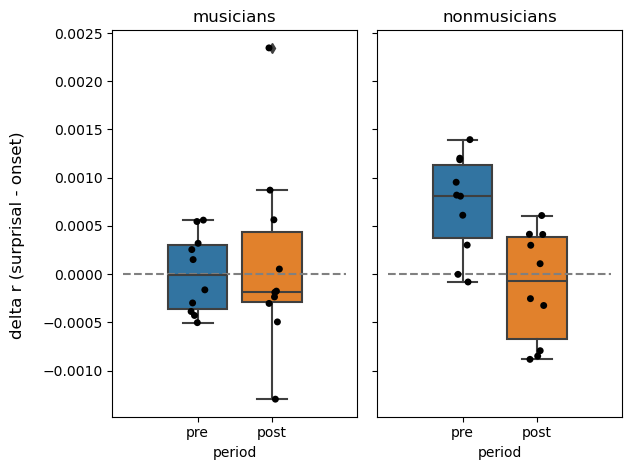

In [78]:
fig, axes = plt.subplots(1,2, sharey = True)

for i, group in enumerate(groups):
    sns.boxplot(data = mTRF_rdiff[mTRF_rdiff['group'] == group], x = 'period', y = 'delta_r', ax = axes[i])
    sns.stripplot(data = mTRF_rdiff[mTRF_rdiff['group'] == group], x = 'period', y = 'delta_r', ax = axes[i], color = 'black')
    axes[i].set_title(group)
    axes[i].set_ylabel('')
    axes[i].hlines(0,-1,2, color = 'grey', linestyles = "--")

fig.supylabel('delta r (surprisal - onset)')
plt.tight_layout()

In [80]:
_,stimuli_list_normalized = normalize_eeg_stimuli(['10'], 'listen', 'post', features = 'AM')


PROCESSING SUBJECT  10
Opening eeg_listen_post_10.mat


In [83]:
stimuli_list_normalized[0].shape

(85120, 2)

In [93]:
testlist = [0, 0, 0, 1, 5, 0, 0, 0, 7]

In [86]:
import random

In [95]:
import random

def shuffle_surprisal(stimuli):
    """
    Shuffles surprisal values (but NOT the onset positions) in a stimuli support vector. 
    stimuli: a vector of shape timepoints x features (2 features: onset and stimuli)
        (if working with normalized stimuli lists, input the index: stimuli_list_normalized[i])
    returns the stimuli array 
    """
    # Find indices of non-zero values
    nonzero_indices = [i for i, x in enumerate(stimuli) if x != 0]
    # Extract non-zero values
    nonzero_values = [stimuli[i] for i in nonzero_indices]

    # Shuffle the non-zero values
    random.shuffle(nonzero_values)

    # Place the shuffled non-zero values back into the original list
    for j, idx in enumerate(nonzero_indices):
        stimuli[idx] = nonzero_values[j]

    return stimuli

# Example usage
testlist = [0, 0, 0, 1, 5, 0, 0, 0, 7]
print(shuffle_surprisal(testlist))


[0, 0, 0, 7, 5, 0, 0, 0, 1]
